In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from nltk import download
download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv("lazadalabel.csv")
print(data.shape)
data.head()

(2009, 5)


,nama,tanggal,ulasan,ringkasan,label
0,Joleen Lamaro,"July 8, 2021","Aplikasi ini akan membantu dengan cara yang mudah. Ini membantu orang-orang yang tidak bisa keluar atau jauh di pasar, itu sangat berguna bagi mereka biasanya bagi saya. Pengalaman saya sangat bag...",aplikasi sangat membantu dan banyak potongan harga serta voucher,1
1,Leah Pejida,"July 12, 2021",Platform belanja online ini didesain sempurna untuk kita para pelanggan yang lebih memilih berbelanja online daripada keluar rumah karena pandemi. Fitur yang paling terpuji dari aplikasi ini adala...,platform belanja online yang sempurna dengan pengiriman yang cepat,1
2,RACHEL RAYMUNDO,"July 9, 2021",Suka! memiliki aplikasi ini selama bertahun-tahun sekarang dan itu telah menjadi aplikasi saya ketika pandemi dimulai. Lazada membuatnya sangat nyaman dan terus menjadi lebih baik. Pengiriman cepa...,"pengiriman cepat, produk asli dengan harga terjangkau",1
3,moi dudzki,"July 12, 2021",Situs belanja online yang mudah dinavigasi.. pemenang untuk setiap game jelas dan terutama mekanismenya. Saya suka promosi dan diskon yang ditawarkan. Saya pikir satu-satunya kejatuhan adalah goya...,mudah digunakan suka diskon dan promo yang ditawarkan,1
4,Marjo yang luar biasa,"July 12, 2021",Aplikasi ini luar biasa! Ini jelas menunjukkan kebutuhan pelanggan. Ini juga memiliki daftar bersih dari hal-hal yang membuatnya dapat diakses dan mudah digunakan. Lazada juga memberikan tanggapan...,aplikasi yang luar biasa mudah digunakan,1


In [ ]:
# Check for any nulls values
data.isnull().sum()

nama         0
tanggal      0
ulasan       0
ringkasan    0
label        0
dtype: int64

In [ ]:
#CaseFolding
data['ulasan'] = data['ulasan'].str.lower()

print('Case Folding Result :\n')
print(data['ulasan'].head(5))

Case Folding Result :

0    aplikasi ini akan membantu dengan cara yang mudah. ini membantu orang-orang yang tidak bisa keluar atau jauh di pasar, itu sangat berguna bagi mereka biasanya bagi saya. pengalaman saya sangat bag...
1    platform belanja online ini didesain sempurna untuk kita para pelanggan yang lebih memilih berbelanja online daripada keluar rumah karena pandemi. fitur yang paling terpuji dari aplikasi ini adala...
2    suka! memiliki aplikasi ini selama bertahun-tahun sekarang dan itu telah menjadi aplikasi saya ketika pandemi dimulai. lazada membuatnya sangat nyaman dan terus menjadi lebih baik. pengiriman cepa...
3    situs belanja online yang mudah dinavigasi.. pemenang untuk setiap game jelas dan terutama mekanismenya. saya suka promosi dan diskon yang ditawarkan. saya pikir satu-satunya kejatuhan adalah goya...
4    aplikasi ini luar biasa! ini jelas menunjukkan kebutuhan pelanggan. ini juga memiliki daftar bersih dari hal-hal yang membuatnya dapat diakses dan mudah

In [ ]:
#CaseFolding
data['ringkasan'] = data['ringkasan'].str.lower()

print('Case Folding Result :\n')
print(data['ringkasan'].head(5))

Case Folding Result :

0      aplikasi sangat membantu dan banyak potongan harga serta voucher
1    platform belanja online yang sempurna dengan pengiriman yang cepat
2                 pengiriman cepat, produk asli dengan harga terjangkau
3                 mudah digunakan suka diskon dan promo yang ditawarkan
4                              aplikasi yang luar biasa mudah digunakan
Name: ringkasan, dtype: object


In [ ]:
stop_words = set(stopwords.words('indonesian')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['ulasan']:
    cleaned_text.append(text_cleaner(t))

In [ ]:
def summary_cleaner(text):
    newString = re.sub('"','', text)   
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['ringkasan']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
# let's inspect some clean reviews
for i in range(4):
    print("Data: ",i+1)
    print(cleaned_text[i])
    print('-'*80)
    print(cleaned_summary[i])
    print()

Data:  1
aplikasi membantu mudah membantu orang orang pasar berguna pengalaman bagus toko legit menjual produk berkualitas harga murah bijak menemukan toko penjual bagus penilaian gambar kuncinya salah toko belanja mudah dinavigasi penjualan potongan harga kupon voucher gratis
--------------------------------------------------------------------------------
aplikasi sangat membantu dan banyak potongan harga serta voucher 

Data:  2
platform belanja online didesain sempurna pelanggan memilih berbelanja online rumah pandemi fitur terpuji aplikasi pengirimannya barang pesan tanggal dikirim pertumbuhan kesuksesan berkelanjutan kesenangan pengalaman terima kasih lazada
--------------------------------------------------------------------------------
platform belanja online yang sempurna dengan pengiriman yang cepat 

Data:  3
suka memiliki aplikasi bertahun aplikasi pandemi lazada membuatnya nyaman pengiriman cepat produk asli harga terjangkau diskon bantuan app dimiliki orang
---------------

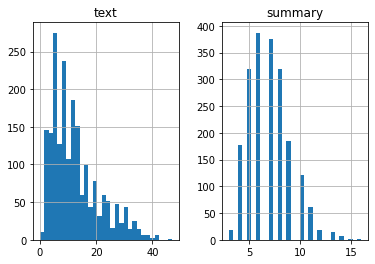

In [ ]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
count = 0
for i in cleaned_text:
    if(len(i.split())<=50):
        count += 1
print(count/len(cleaned_text))

1.0


In [ ]:
count = 0
for i in cleaned_summary:
    if(len(i.split())<=14):
        count += 1
print(count/len(cleaned_summary))

1.0


In [ ]:
max_summary_len=15
max_text_len=50

cleaned_text = np.array(cleaned_text)
cleaned_summary = np.array(cleaned_summary)

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
df.head()

,text,summary
0,aplikasi membantu mudah membantu orang orang pasar berguna pengalaman bagus toko legit menjual produk berkualitas harga murah bijak menemukan toko penjual bagus penilaian gambar kuncinya salah tok...,sostok aplikasi sangat membantu dan banyak potongan harga serta voucher eostok
1,platform belanja online didesain sempurna pelanggan memilih berbelanja online rumah pandemi fitur terpuji aplikasi pengirimannya barang pesan tanggal dikirim pertumbuhan kesuksesan berkelanjutan k...,sostok platform belanja online yang sempurna dengan pengiriman yang cepat eostok
2,suka memiliki aplikasi bertahun aplikasi pandemi lazada membuatnya nyaman pengiriman cepat produk asli harga terjangkau diskon bantuan app dimiliki orang,sostok pengiriman cepat produk asli dengan harga terjangkau eostok
3,situs belanja online mudah dinavigasi pemenang game mekanismenya suka promosi diskon ditawarkan pikir satunya kejatuhan goyang muncul mengguncangnya voucher diganti dompet lazada voucher transaksi...,sostok mudah digunakan suka diskon dan promo yang ditawarkan eostok
4,aplikasi kebutuhan pelanggan memiliki daftar bersih membuatnya diakses mudah lazada tanggapan tindakan layanan pelanggan disarankan keamanan terjamin butuhkan tersedia,sostok aplikasi yang luar biasa mudah digunakan eostok


Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

x_voc

% of rare words in vocabulary: 70.13527575442248
Total Coverage of rare words: 13.000359001974509


862

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)

% of rare words in vocabulary: 76.74632352941177
Total Coverage of rare words: 11.93172754825331


(1808, 1808)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 50, 200)      172400      input_10[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 50, 300), (N 601200      embedding_6[0][0]                
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Train on 1803 samples, validate on 201 samples
Epoch 1/50
1803/1803 [==============================] - 67s 37ms/sample - loss: 2.5219 - val_loss: 1.8138
Epoch 2/50
1803/1803 [==============================] - 56s 31ms/sample - loss: 1.7243 - val_loss: 1.7199
Epoch 3/50
1803/1803 [==============================] - 55s 31ms/sample - loss: 1.6314 - val_loss: 1.6744
Epoch 4/50
1803/1803 [==============================] - 55s 31ms/sample - loss: 1.5580 - val_loss: 1.6070
Epoch 5/50
1803/1803 [==============================] - 55s 31ms/sample - loss: 1.5166 - val_loss: 1.5604
Epoch 6/50
1803/1803 [==============================] - 55s 30ms/sample - loss: 1.4853 - val_loss: 1.5387
Epoch 7/50
1803/1803 [==============================] - 55s 30ms/sample - loss: 1.4562 - val_loss: 1.5227
Epoch 8/50
1803/1803 [==============================] - 55s 30ms/sample - loss: 1.4267 - val_loss: 1.4992
Epoch 9/50
1803/1803 [==============================] - 55s 30ms/sample - loss: 1.4011 - val_loss: 1.4783

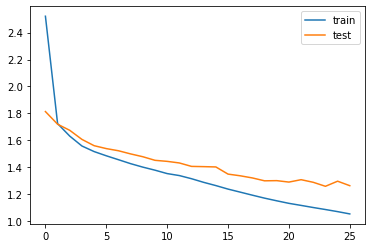

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:
for i in range(0, 30):
    print ('Review:', seq2text(x_tr[i]))
    print ('Summary:', seq2summary(y_tr[i]))
    print ('\n')

Review: belanja online terbaik aplikasi memiliki bug macet berharap pengembang tim aplikasi platform belanja versi kinerja bagus aplikasi memiliki gelap 
Summary: memiliki bug dan beberapa macet 


Review: platform online berguna pilihan 
Summary: berguna banyak pilihan 


Review: aplikasi bagus salah pesanan keluhan lazada terbatas 
Summary: lazada terbatas 


Review: produk mahal toko aplikasi bagus 
Summary: produk lebih mahal 


Review: mudah lag menghabiskan baterai ponsel 
Summary: dan banyak baterai 


Review: foto foto pembelian aplikasi lambat 
Summary: foto pembelian tidak dapat 


Review: menemukan butuhkan terima kasih 
Summary: menemukan semua yang 


Review: mudah dibandingkan peta sulit 
Summary: mudah tapi sulit 


Review: senang lazada sesuai kebutuhan klien 
Summary: sesuai dengan kebutuhan 


Review: mengubah alamat default pembayaran alamat pekerjaan uang dikirim alamat terbaru 
Summary: tidak dapat mengubah alamat 


Review: pengiriman cepat shopee app membantu men